# Building a language detector

In this project I use [European Parliament Proceedings Parallel Corpus](http://www.statmt.org/europarl/) (a text dataset used for evaluating language detection engines) to build a logistic classifier. 

I compare the bag of word approach with a n-gram model. 

The 1.5GB corpus includes 21 languages spoken in EU. 

The Europarl parallel corpus is extracted from the proceedings of the European Parliament. It includes versions in 21 European languages: Romanic (French, Italian, Spanish, Portuguese, Romanian), Germanic (English, Dutch, German, Danish, Swedish), Slavik (Bulgarian, Czech, Polish, Slovak, Slovene), Finni-Ugric (Finnish, Hungarian, Estonian), Baltic (Latvian, Lithuanian), and Greek.

All formats contain document $(<$CHAPTER id$>)$, speaker $(<$SPEAKER id name language$>)$, and paragraph $(<$P$>)$ mark-up on a separate line. The data is stored in one file per day, and in smaller units for newer data.

###  Script initialization

In [139]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import glob
import re
import csv

In [140]:
import sys, sklearn
print('Python:  ' + sys.version.split('\n')[0])
print('         ' + sys.version.split('\n')[1])
print('Pandas:  ' + pd.__version__)
print('Numpy:   ' + np.__version__)
print('Sklearn: ' + sklearn.__version__)

Python:  3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) 
         [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas:  0.20.3
Numpy:   1.13.3
Sklearn: 0.19.1


### Read files

In [217]:
def read_lang_files(path):
    """ Returns a list with all the files read """
    lang_list = []
    all_files = glob.glob(path)
    
    for file in all_files:
        file_txt = open(file,"r",errors='ignore')
        file_read = file_txt.read()
        if file_read != '':
            lang_list.append(file_read)
            file_txt.close()
        
    return lang_list

In [142]:
# All the countries existing in the European data set
countries = ['bg','cs','da','de','el','en','es','et','fi','fr','hu',
             'it','lt','lv','nl','pl','pt','ro','sk','sl','sv']

In [144]:
#import all the language texts
bg = read_lang_files('./txt/bg/*.txt')
cs = read_lang_files('./txt/cs/*.txt')
da = read_lang_files('./txt/da/*.txt')
de = read_lang_files('./txt/de/*.txt')
el = read_lang_files('./txt/el/*.txt')
en = read_lang_files('./txt/en/*.txt')
es = read_lang_files('./txt/es/*.txt')
et = read_lang_files('./txt/et/*.txt')
fi = read_lang_files('./txt/fi/*.txt')
fr = read_lang_files('./txt/fr/*.txt')
hu = read_lang_files('./txt/hu/*.txt')
it = read_lang_files('./txt/it/*.txt')
lt = read_lang_files('./txt/lt/*.txt')
lv = read_lang_files('./txt/lv/*.txt')
nl = read_lang_files('./txt/nl/*.txt')
pl = read_lang_files('./txt/pl/*.txt')
pt = read_lang_files('./txt/pt/*.txt')
ro = read_lang_files('./txt/ro/*.txt')
sk = read_lang_files('./txt/sk/*.txt')
sl = read_lang_files('./txt/sl/*.txt')
sv = read_lang_files('./txt/sv/*.txt')

country_data = [bg,cs,da,de,el,en,es,et,fi,fr,hu,it,lt,lv,nl,pl,pt,ro,sk,sl,sv]

### Raw data 

In [392]:
for i, country in enumerate(country_data):
    print("{} example: ".format(countries[i]))
    print("{}".format(country[0]))
    print('\n')

bg example: 
['Второ, съжалявам, че се появи малко изкуствено противопоставяне по въпроса за данък върху финансовите операции и че има две много подобни изменения. Съжалявам, че в резултат на това Парламентът не може да изрази категорична подкрепа за този данък при условия, които са разумни по отношение на конкурентоспособността на Европа.(DE) Г-жо председател, мога да кажа на г-н Gauzès следното: да, възнамеряваме да оттеглим проекта на алтернативна резолюция. Препоръчах го на моята група поради една много проста причина: следващото изменение, подписано от  колеги от всички групи, показва, че предложенията относно данък върху финансовите операции не са запазена марка на която и да е група, независимо дали социалистите, консерваторите, групата на Европейската народна партия (Християндемократи) или групата на Зелените/Европейски свободен алианс. Въпросът е, че правим институционално предложение и изпращаме институционално послание, че залата е в състояние да каже на междупартийна основа

###  Clean data
Let's clean the data by remove new line, numbers and split on paragraphs. Then split on the paragraphs and save these in a list. 

In [146]:
def clean_data(lang_file):
    for ind,file in enumerate(lang_file):
        c_file = re.sub('\\n', '', file) #remove \n
        c_file = re.sub('\d', '', c_file) #remove numbers
        c_file = c_file.split('<P>') #Seperate on paragraphs
        cc_file = []
        for count,item in enumerate(c_file):
            item_c = re.sub('<[^>]+>', '', item)
            if not re.match(r'[\W_]+', item_c) and item_c != '': #check if only special char or emtpy
                cc_file.append(item_c)        
        lang_file[ind] = cc_file

In [147]:
for country in country_data:
    clean_data(country)

### Store in data frame
Put all the paragraphs in a dataframe together with their respective language label. 

In [148]:
df = pd.DataFrame({'num' : [],'paragraphs' : [], 'language': []})

In [149]:
for count, country in enumerate(country_data):
    flat_list = [item for sublist in country for item in sublist] #flatten the data 
    dict_new = {'num':[count]*len(flat_list),'paragraphs':flat_list,
                'language':['{}'.format(countries[count])]*len(flat_list)}
    df_new = pd.DataFrame.from_dict(dict_new)
    df = pd.concat([df, df_new])

In [150]:
df.head()

,language,num,paragraphs
0,bg,0.0,"Второ, съжалявам, че се появи малко изкуствено..."
1,bg,0.0,Поправки и намерения за гласуване: вж. протоколи
2,bg,0.0,Въпроси за устен отговор и писмени декларации ...
3,bg,0.0,Писмени декларации (внасяне): вж. протокола
4,bg,0.0,Положението в Република Молдова (разискване)Сл...


In [151]:
df.tail()

,language,num,paragraphs
500084,sv,20.0,Unionen måste vidta åtgärder för att öka sin f...
500085,sv,20.0,Vi får i synnerhet inte glömma bort européerna...
500086,sv,20.0,Beslut om vissa dokument: se protokollet
500087,sv,20.0,Rättelser/avsiktsförklaringar till avgivna rös...
500088,sv,20.0,Framställningar: se protokollet


In [152]:
df['language'].unique()

array(['bg', 'cs', 'da', 'de', 'el', 'en', 'es', 'et', 'fi', 'fr', 'hu',
       'it', 'lt', 'lv', 'nl', 'pl', 'pt', 'ro', 'sk', 'sl', 'sv'], dtype=object)

### Look at one  example for each language

In [153]:
for lang in df['language'].unique():
    print("{} example: ".format(lang))
    print("{}".format(df[df['language']==lang].iloc[0]['paragraphs']))
    print('\n')

bg example: 
Второ, съжалявам, че се появи малко изкуствено противопоставяне по въпроса за данък върху финансовите операции и че има две много подобни изменения. Съжалявам, че в резултат на това Парламентът не може да изрази категорична подкрепа за този данък при условия, които са разумни по отношение на конкурентоспособността на Европа.(DE) Г-жо председател, мога да кажа на г-н Gauzès следното: да, възнамеряваме да оттеглим проекта на алтернативна резолюция. Препоръчах го на моята група поради една много проста причина: следващото изменение, подписано от  колеги от всички групи, показва, че предложенията относно данък върху финансовите операции не са запазена марка на която и да е група, независимо дали социалистите, консерваторите, групата на Европейската народна партия (Християндемократи) или групата на Зелените/Европейски свободен алианс. Въпросът е, че правим институционално предложение и изпращаме институционално послание, че залата е в състояние да каже на междупартийна основа: 

Secondly, I regret that a slightly artificial opposition has emerged on the issue of a tax on financial transactions and that there are two very similar amendments. I regret that, as a result, Parliament cannot express its overwhelming support for this tax in conditions that are reasonable with regard to Europe's competitiveness.(DE) Madam President, I can tell Mr Gauzès this: yes, we intend withdrawing this draft for an alternative resolution. I recommended this to my group for a very simple reason: The following amendment, which has been signed by  Members from all groups, shows that proposals regarding a financial transaction tax are not the preserve of any one group, whether the socialists, conservatives, the Group of the European People's Party (Christian Democrats) or the Group of the Greens/European Free Alliance. The point is that we are making an institutional proposal and issuing an institutional signal that this House is capable of saying on a cross-party basis: 'We want the

In secondo luogo, mi rincresce che sia emersa una opposizione leggermente artificiosa riguardo alla questione della tassa sulle transazioni finanziarie e che esistano due emendamenti molto simili. Di conseguenza mi rincresce che il Parlamento non possa esprimere il pieno sostegno per questa imposizione alle condizioni più ragionevoli per la competitività dell'Europa.(DE) Signora Presidente, rispondo all'onorevole Gauzès che, sì, intendiamo ritirare questa proposta di risoluzione alternativa e ho invitato il mio gruppo a procedere in tal senso per un motivo molto semplice: l'emendamento sottoscritto dai  membri di tutti i gruppi dimostra che le proposte relative alla tassa sulle transazioni finanziarie non sono appannaggio di alcun gruppo in particolare, sia esso socialista, conservatore, il gruppo del Partito popolare europeo (Democratico cristiano) o il gruppo Verde/Alleanza libera europea. Il punto è che stiamo formulando una proposta istituzionale e lanciando un segnale istituzional

Em segundo lugar, lamento que uma oposição algo artificial tenha emergido sobre a questão do imposto sobre transacções financeiras e que existam duas alterações muito semelhantes. Lamento que, como resultado disso, o Parlamento não possa expressar o seu apoio esmagador a esse imposto em condições que sejam razoáveis face à competitividade da Europa.(DE) Senhora Presidente, posso dizer ao senhor deputado Jean-Paul Gauzès o seguinte: sim, tencionamos retirar esta proposta de resolução alternativa. Foi essa a recomendação que fiz ao meu Grupo e por uma razão muito simples: a alteração que se segue, que foi assinada por  deputados de todos os grupos, mostra que as propostas relativas a um imposto sobre transacções financeiras não são propriedade de qualquer Grupo, dos Conservadores, dos Socialistas, do Grupo do Partido Popular Europeu (Democratas-Cristãos), ou do Grupo dos Verdes/Aliança Livre Europeia. A ideia é apresentar uma proposta institucional e emitir um sinal institucional de que 

### Save data for future use

In [154]:
df.to_csv('./Clean/clean_all_data.csv', encoding='utf-8', index=False)

In [155]:
df_lan = pd.read_csv('./Clean/clean_all_data.csv')

In [156]:
df_lan.head()

,language,num,paragraphs
0,bg,0.0,"Второ, съжалявам, че се появи малко изкуствено..."
1,bg,0.0,Поправки и намерения за гласуване: вж. протоколи
2,bg,0.0,Въпроси за устен отговор и писмени декларации ...
3,bg,0.0,Писмени декларации (внасяне): вж. протокола
4,bg,0.0,Положението в Република Молдова (разискване)Сл...


### Data overview

In [157]:
#class balance
df_lan.groupby('language').count()

,num,paragraphs
language,,
bg,91645,91645
cs,158268,158268
da,519588,519588
de,505058,505058
el,352257,352257
en,536291,536291
es,511893,511893
et,157576,157576
fi,496075,496075


### To simplify the analyzis I will only use the first 500 paragraphs for each language for now

In [158]:
df_small = pd.DataFrame({'num' : [],'paragraphs' : [], 'language': []})

In [159]:
for lang in df['language'].unique():
    df_temp = df[df['language']==lang].iloc[:500]
    df_small = pd.concat([df_small, df_temp])

In [160]:
df_small['language'].value_counts()

nl    500
de    500
da    500
it    500
lv    500
sk    500
pt    500
en    500
es    500
el    500
sl    500
fi    500
cs    500
et    500
lt    500
ro    500
bg    500
pl    500
sv    500
fr    500
hu    500
Name: language, dtype: int64

In [161]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+') #splits on anything that is not an alphanumeric character

df_small['tokens'] = df_small['paragraphs'].apply(tokenizer.tokenize)
df_small.head()

,language,num,paragraphs,tokens
0,bg,0.0,"Второ, съжалявам, че се появи малко изкуствено...","[Второ, съжалявам, че, се, появи, малко, изкус..."
1,bg,0.0,Поправки и намерения за гласуване: вж. протоколи,"[Поправки, и, намерения, за, гласуване, вж, пр..."
2,bg,0.0,Въпроси за устен отговор и писмени декларации ...,"[Въпроси, за, устен, отговор, и, писмени, декл..."
3,bg,0.0,Писмени декларации (внасяне): вж. протокола,"[Писмени, декларации, внасяне, вж, протокола]"
4,bg,0.0,Положението в Република Молдова (разискване)Сл...,"[Положението, в, Република, Молдова, разискван..."


### The total word count

In [162]:
for lang in df['language'].unique():
    all_words = [word for tokens in df_small[df_small['language']==lang]['tokens'] for word in tokens]
    VOCAB = sorted(list(set(all_words)))
    print("{} example: ".format(lang))
    print("{} words total, with a vocabulary size of {}".format(len(all_words), len(VOCAB)))
    print("\n")

bg example: 
44737 words total, with a vocabulary size of 7803


cs example: 
38509 words total, with a vocabulary size of 9063


da example: 
35196 words total, with a vocabulary size of 5622


de example: 
35554 words total, with a vocabulary size of 6526


el example: 
44044 words total, with a vocabulary size of 8009


en example: 
40435 words total, with a vocabulary size of 4550


es example: 
40676 words total, with a vocabulary size of 5602


et example: 
33238 words total, with a vocabulary size of 9540


fi example: 
25992 words total, with a vocabulary size of 8908


fr example: 
43351 words total, with a vocabulary size of 5375


hu example: 
38324 words total, with a vocabulary size of 10196


it example: 
38215 words total, with a vocabulary size of 5573


lt example: 
34007 words total, with a vocabulary size of 9009


lv example: 
36120 words total, with a vocabulary size of 8757


nl example: 
39937 words total, with a vocabulary size of 5183


pl example: 
38914 words

## Making a language classifier

### Bag of Words Counts (1st model)

The simplest approach we can start with is to use a bag of words model, and apply a logistic regression on top. A bag of words just associates an index to each word in our vocabulary, and embeds each sentence as a list of 0s, with a 1 at each index corresponding to a word present in the sentence.

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = df_small['paragraphs'].tolist()
list_labels = df_small['num'].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Fitting a logistic classifier

In [164]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)

clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [165]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted_counts, target_names=df_small['language'].unique()))

             precision    recall  f1-score   support

         bg       1.00      1.00      1.00        83
         cs       0.98      1.00      0.99       100
         da       1.00      0.98      0.99        93
         de       1.00      0.98      0.99       107
         el       1.00      0.99      1.00       114
         en       0.99      0.99      0.99        83
         es       1.00      1.00      1.00       105
         et       1.00      1.00      1.00        91
         fi       1.00      1.00      1.00       108
         fr       1.00      0.97      0.98        99
         hu       1.00      0.97      0.98        99
         it       1.00      0.96      0.98       109
         lt       0.99      1.00      0.99        93
         lv       0.98      0.99      0.99       103
         nl       1.00      1.00      1.00       103
         pl       0.89      1.00      0.94        85
         pt       1.00      0.99      1.00       110
         ro       1.00      1.00      1.00   

In [166]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predicted_counts)

In [167]:
percentage_matrix = 100*cm/cm.sum(axis=1).astype(float)

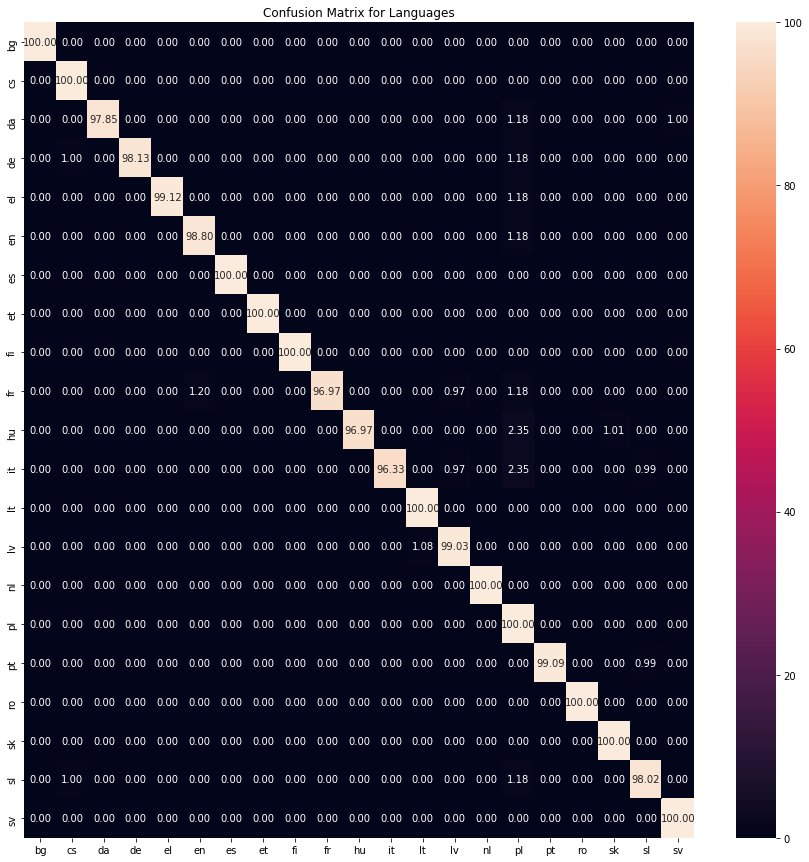

In [168]:
plt.figure(figsize=(15, 15))
sns.heatmap(percentage_matrix, annot=True,  fmt='.2f', xticklabels=countries, yticklabels=countries);
plt.title('Confusion Matrix for Languages');

### Look at most important and less important words

In [185]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
                                'tops':tops,
                                'bottom':bottom
                                }
    return classes

importance = get_most_important_features(count_vectorizer, clf, n=20)

In [197]:
print('The top words are')
all_top = []
for i, lang in enumerate(countries): 
    top_words = [a[1] for a in importance[i]['tops']]
    all_top += top_words
    print("{} TOP WORDS: ".format(lang))
    print(*top_words)
    print('\n')


The top words are
bg TOP WORDS: 
график следващите време че ред дневен откриване от петиции ще протоколи се заседанието протокола за да разискването приключи вж на


cs TOP WORDS: 
na které žen jsou hlasování že orig překlad špatný ve rozprava této ukončena se byla pro zahájení viz zápis zasedání


da TOP WORDS: 
afsluttet hermed forhandlingen følgende stemt at af kommissionen derfor kl afstemningen sted finder har andenbehandling indstilling ved og er ændringsforslag


de TOP WORDS: 
ist sie stimmen für werden anhang standpunkt kommission artikel go schriftliche erklärungen änderungsanträge mehr der dagegen deshalb und wir die


el TOP WORDS: 
να αποδεκτές δεύτερη ανάγνωση σύσταση στις έκθεση τη βλ συνοπτικά πρακτικά είναι για οι ψηφοφορία διεξαχθεί τροπολογίες και την θα


en TOP WORDS: 
to this closed and is has of amendments we against voted for therefore recommendation second reading position annex commission the


es TOP WORDS: 
segunda anexo del de posición lectura recomendación

In [198]:
print('The bottom words are')
all_bottom = []
for i, lang in enumerate(countries): 
    bottom_words = [a[1] for a in importance[i]['bottom']]
    all_bottom += bottom_words
    print("{} BOTTOM WORDS: ".format(lang))
    print(*bottom_words)
    print('\n')
    

The bottom words are
bg BOTTOM WORDS: 
debate le şedinţei to die in ter do és savary jarzembowski je un se na on la ir ja de


cs BOTTOM WORDS: 
bodom som şedinţei die savary da rechazan jarzembowski in és ter debate la sa enmiendas on un ir de ja


da BOTTOM WORDS: 
se följande on ändringsförslag humankapitalet väl uttryck kommentarer inga ir mycket därför röstat ja jag la detta emot att och


de BOTTOM WORDS: 
monaten nationalen seit regierungen meiner sicht währung erleben fähigkeit tegengestemd redenen wij la hebben ir al ja om de krise


el BOTTOM WORDS: 
debate на le ter to és do in die andrabehandlingsrekommendation jarzembowski un je se na on ir la ja de


en BOTTOM WORDS: 
ter der és encerrado está za die do le en un andrabehandlingsrekommendation et je ir na se ja la de


es BOTTOM WORDS: 
os in leitura recomendação les chiusa pour discussione as pentru não com um să da je des et na do


et BOTTOM WORDS: 
tämä hylkää voidaan jotka lisäksi se je un päättynyt eu keskustelu ir l

In [200]:
print("Out of {} of the top words, {} are unique".format(len(countries)*20,len(set(all_top))))
print("Out of {} of the bottom words, {} are unique".format(len(countries)*20,len(set(all_bottom))))

Out of 420 of the top words, 397 are unique
Out of 420 of the bottom words, 179 are unique


## Conclusions (Bag of Words Counts)

With bag of words we can get rather good accuracy. We also see that our top words tend to be unique for that language, while for the bottom word there is a lot of duplicates.  

However, generally languages have various prefixes, suffixes and other small word parts that are specific to them. For suffixes, "-able", "-ness", "-s/tion", "-ist" are very common. For prefixes, "a-", "co-", "counter-", "ex-", "dis-", "mal-", "pre-", "under-", "up-", "re-" and "pro-". With a word based tokenization we are not able to get these small language specific parts which are quite important for language detection.

### Vectorizer (2nd try)
[TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) - Equivalent to CountVectorizer followed by TfidfTransformer. 

The reason this might work better is because using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus. There might be some words that are present in most languages. Also, using n_gram could help us detect the small language specific parts mentioned above.

In [175]:
from sklearn.feature_extraction.text import TfidfVectorizer 


def cv(data):
    vectorizer = TfidfVectorizer(ngram_range=(1, 6),analyzer='char') #Use n_grams
    emb = vectorizer.fit_transform(data)

    return emb, vectorizer

X_train_vect, vectorizer = cv(X_train)
X_test_vect = vectorizer.transform(X_test)

### Logistic classifier

In [176]:
clf_vect = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)

clf_vect.fit(X_train_vect, y_train)

y_predicted_vect = clf_vect.predict(X_test_vect)

In [177]:
cm_vect = confusion_matrix(y_test, y_predicted_vect)
percentage_matrix_vect = 100*cm_vect/cm_vect.sum(axis=1).astype(float)

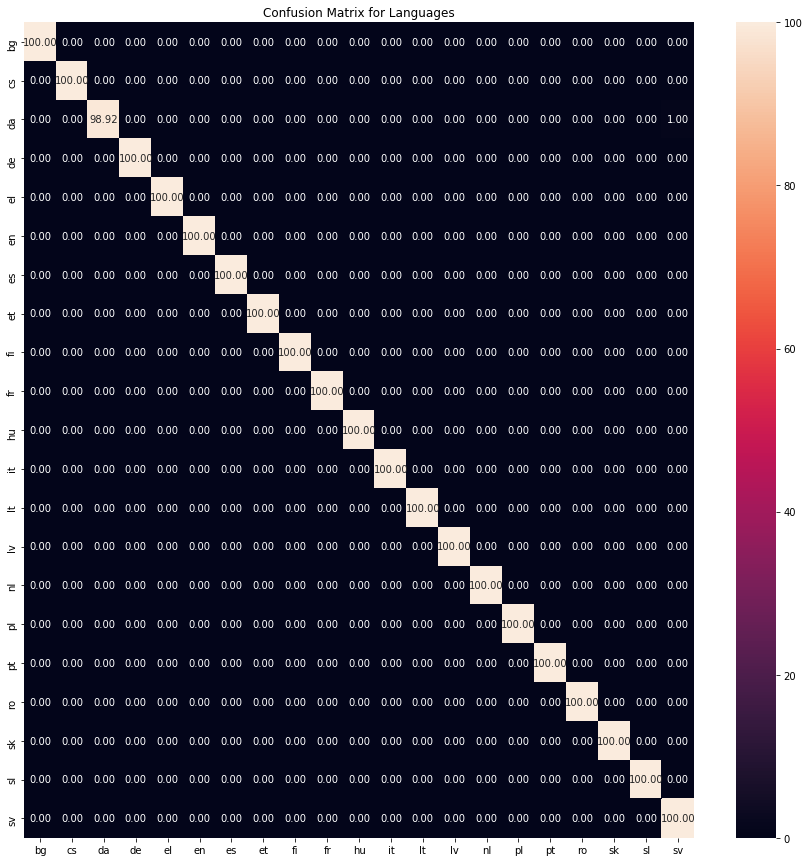

In [178]:
plt.figure(figsize=(15, 15))
sns.heatmap(percentage_matrix_vect, annot=True,  fmt='.2f', xticklabels=countries, yticklabels=countries);
plt.title('Confusion Matrix for Languages');

In [201]:
importance_vec = get_most_important_features(vectorizer, clf_vect, n=20)

In [207]:
all_top_vec = []
all_bottom_vec = []

for i, lang in enumerate(countries): 
    top_words_vec = [a[1] for a in importance_vec[i]['tops']]
    bottom_words_vec = [a[1] for a in importance_vec[i]['bottom']]
    
    print("{} TOP WORDS: ".format(lang))
    print(*top_words_vec)
    print("{} BOTTOM WORDS: ".format(lang))
    print(*bottom_words_vec)
    print('\n')
    
    all_top_vec += top_words_vec
    all_bottom_vec += bottom_words_vec


bg TOP WORDS: 
то на з м  п е  л п к д а  с в р т н и о е а
bg BOTTOM WORDS: 
, , , p  , ,  , ,   , , , , k u m d l   r s t n o i a e


cs TOP WORDS: 
é  z že v ý ně ě  ž  př př ře ů a ní  á ní í  ř ě í
cs BOTTOM WORDS: 
, , n  ó et ä a  w ľ ť  ú s  ia re s g ie ť e r i


da TOP WORDS: 
er  fo r d fo og  r   for å er   og   at  f  og for g  g e ø æ
da BOTTOM WORDS: 
ei p fö  w o é ör s  i ie ch o  ö w z u a  ä c a


de TOP WORDS: 
ü en  der en  der   die  ie  sch ge w ich ei  die n die  die ung h ch e
de BOTTOM WORDS: 
co l é    c k  p  t i   de  o   o de  y j p v a  a o


el TOP WORDS: 
μ η  λ α  υ  τ ί ς  κ ς σ ρ ν η π ι τ ο ε α
el BOTTOM WORDS: 
en g c v p e  u   k l m d r s o t n i a e


en TOP WORDS: 
and   to     of  d  of   w  and   t t he h w  the  he   the the  the  th th
en BOTTOM WORDS: 
d ie  de  á  k en  de   de v é i  ä u j de a  d z a  k


es TOP WORDS: 
 y  e que   el e s   la   l  y  el   la ión  ón  os  c ue ió  el  ón ión
es BOTTOM WORDS: 
g ä w ai z  e   o ão  ç é m

In [204]:
print("Out of {} of the top words, {} are unique".format(len(countries)*20,len(set(all_top_vec))))
print("Out of {} of the bottom words, {} are unique".format(len(countries)*20,len(set(all_bottom_vec))))

Out of 420 of the top words, 335 are unique
Out of 420 of the bottom words, 120 are unique


## Conclusions (Vectorizer )
We see that instead of classifying whole words, the classifier now looks at certain special characters and their combinations that tend to be unique for that language. This should be more robust, considering we otherwise would have to include a huge amount of words, as the classifier would have trouble with words it had not seen before. As would happen for the bag of words classfier. 

In [210]:
from sklearn.externals import joblib
joblib.dump(clf, './Models/logistic_bag.pkl') 
joblib.dump(clf_vect, './Models/logistic_n_gram.pkl') 

['./Models/logistic_n_gram.pkl']

# Test on different test set

In [257]:
import io
f = io.open("europarl.test", mode="r", encoding="utf-8")

In [258]:
test_file = f.read()

In [265]:
test_list = test_file.split('\n')

In [320]:
test_list[666]

'bg\tПредишният комисар, г-н Bolkestein, беше по-малко убеден и, както много държави-членки, беше скептичен.'

In [288]:
labels_test = [text[:2] for text in test_list[:-2]] #last test_list item is empty

In [289]:
#test for length
set([len(lab) for lab in labels_test])

{2}

In [370]:
label_to_num = dict(zip(countries, np.arange(len(countries))))

In [372]:
label_to_num['bg']

0

In [377]:
y_test_lab = [label_to_num[key] for key in labels_test]

In [351]:
#Remove the first 4 letter
features_test = [item[3:] for item in test_list[:-2]]

In [352]:
'' in features_test

False

### Bag of words

In [353]:
X_test_set_counts = count_vectorizer.transform(features_test)

In [354]:
y_predicted_set_counts = clf.predict(X_test_set_counts)

In [380]:
cm_test_bg = confusion_matrix(y_test_lab, y_predicted_set_counts)
percentage_matrix_test = 100*cm_test_bg/cm_test_bg.sum(axis=1).astype(float)

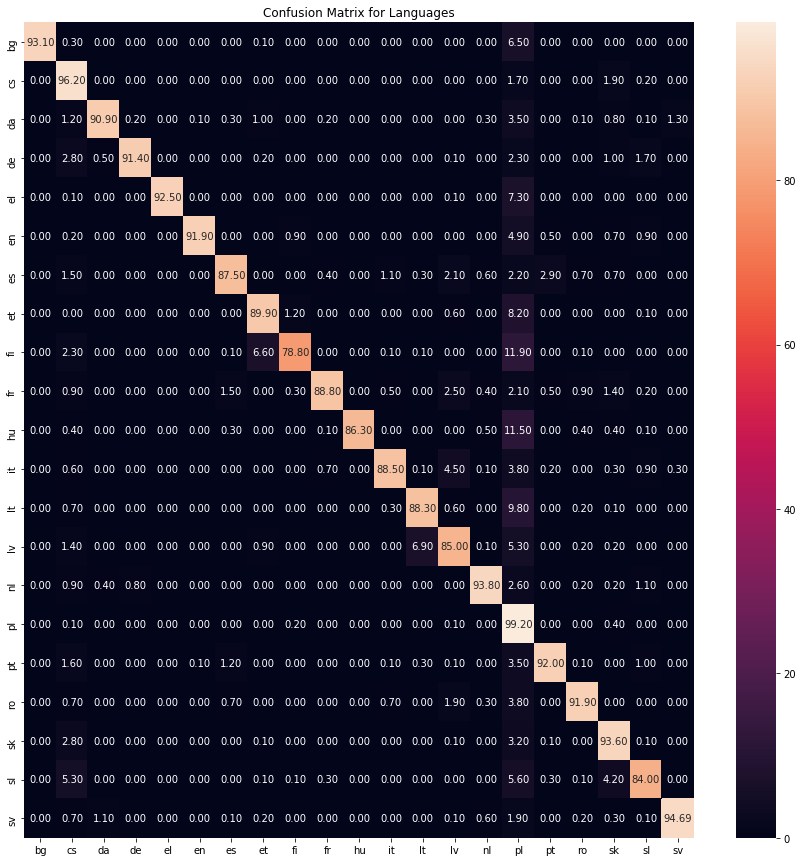

In [381]:
plt.figure(figsize=(15, 15))
sns.heatmap(percentage_matrix_test, annot=True,  fmt='.2f', xticklabels=countries, yticklabels=countries);
plt.title('Confusion Matrix for Languages');

### Vectorizer

In [382]:
X_test_set_vect = vectorizer.transform(features_test)

In [383]:
y_test_predicted_vect = clf_vect.predict(X_test_set_vect)

In [384]:
cm_test_vect = confusion_matrix(y_test_lab, y_test_predicted_vect)
percentage_test_matrix_vect = 100*cm_test_vect/cm_test_vect.sum(axis=1).astype(float)

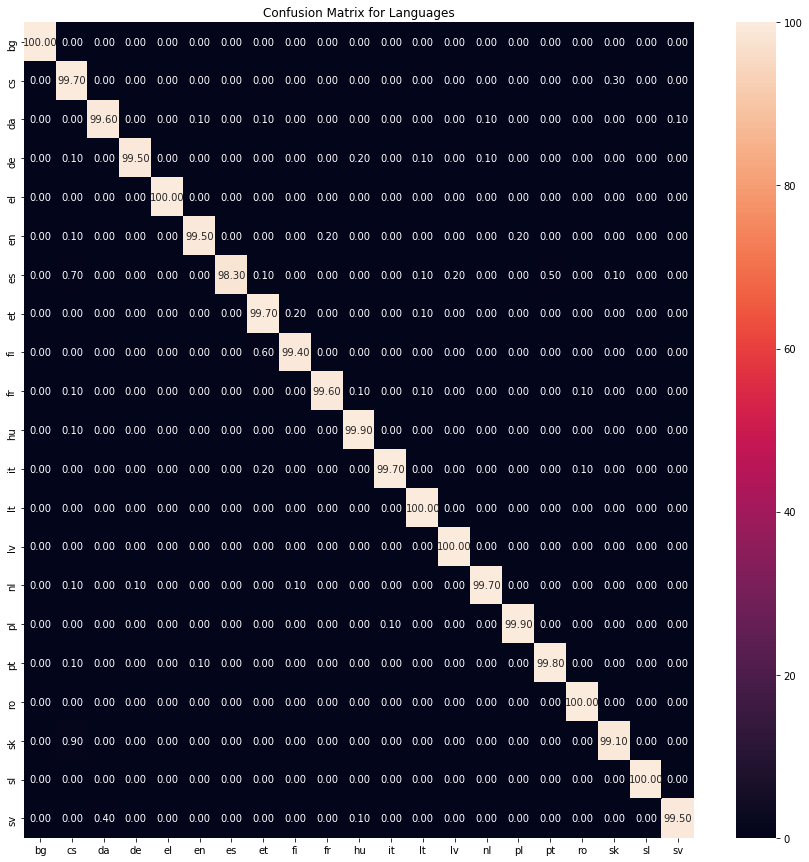

In [385]:
plt.figure(figsize=(15, 15))
sns.heatmap(percentage_test_matrix_vect, annot=True,  fmt='.2f', xticklabels=countries, yticklabels=countries);
plt.title('Confusion Matrix for Languages');

# Conclusions
The vectorizer seems to be a lot better at generalizing to other not yet seen data sets. 